In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Ridge Regression

## Example 1: Boston Housing

### Fetch Data and Main Parameters

In [3]:
# read data
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort3/master/boston.csv")

# pass some parameters
ridge_shrinkage = np.linspace(0.00001, 0.4, num=200)
target = ["T1"]

# generate folds
kf = KFold(n_splits=5, shuffle=True, random_state=10)

### Run Model

In [4]:
# pre-instantiation
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Shrinkage", "Train RMSE", "Test RMSE"])

# main loop
k, f = 0, 0
for (train, test) in kf.split(df):
    f += 1
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
    
    # scale  variables
    scaler_x = StandardScaler().fit(x_train)
    x_train = np.hstack([np.ones((x_train.shape[0], 1)), scaler_x.transform(x_train)])
    x_test = np.hstack([np.ones((x_test.shape[0], 1)), scaler_x.transform(x_test)])
    
    # fit model
    for l in ridge_shrinkage:
        # train model
        inv_component = np.linalg.inv(np.matmul(x_train.transpose(), x_train) + np.eye(x_train.shape[1]) * l * x_train.shape[1])
        coefs = np.matmul(inv_component, np.matmul(x_train.transpose(), y_train))
        
        # get predictions
        pred_train = np.matmul(x_train, coefs)
        pred_test = np.matmul(x_test, coefs)
        
        # compute metrics
        rmse_train = np.sqrt(np.mean((y_train - pred_train) ** 2.0))
        rmse_test = np.sqrt(np.mean((y_test - pred_test) ** 2.0))
        
        # store results
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Shrinkage"] = l
        df_metrics.loc[k, "Train RMSE"] = rmse_train
        df_metrics.loc[k, "Test RMSE"] = rmse_test
        k += 1
        
        # if using sklearn: from sklearn.linear_model import Ridge
        #ml = Ridge(alpha=l).fit(x_train, y_train)
        #pred_train = ml.predict(x_train)
        #pred_test = ml.predict(x_test)

# final organization
df_metrics = df_metrics.astype(float)

### Charts

In [6]:
df_agg_metrics = df_metrics.pivot_table(index="Shrinkage", values=["Train RMSE", "Test RMSE"])

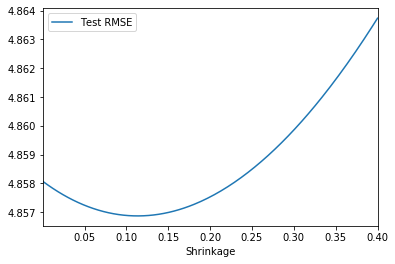

In [8]:
df_agg_metrics[["Test RMSE"]].plot()

In [9]:
df_agg_metrics.loc[df_agg_metrics["Test RMSE"].idxmin()]

Test RMSE     4.856875
Train RMSE    4.653663
Name: 0.11257, dtype: float64

## Example 2: Boston Housing with Polynomial Features

### Some new params

In [41]:
from sklearn.preprocessing import PolynomialFeatures
poly_params = {"degree": 3,
               "interaction_only": False,
               "include_bias": True
              }

In [22]:
poly_func = PolynomialFeatures(**poly_params).fit(df.drop(labels=target, axis=1))
x_train = poly_func.transform(df.drop(labels=target, axis=1))

In [23]:
x_train.shape

(506, 560)

In [13]:
df.drop(labels=target, axis=1).shape

(506, 13)

### Main Loop

In [42]:
# pre-instantiation
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Shrinkage", "Train RMSE", "Test RMSE"])

# main loop
k, f = 0, 0
for (train, test) in kf.split(df):
    f += 1
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
    
    # scale variables
    scaler_x = StandardScaler().fit(x_train)
    x_train = scaler_x.transform(x_train)
    x_test = scaler_x.transform(x_test)
    
    # polynomial features - will include bias automatically
    poly_func = PolynomialFeatures(**poly_params).fit(x_train)
    x_train = poly_func.transform(x_train)
    x_test = poly_func.transform(x_test)
        
    # fit model
    for l in ridge_shrinkage:
        # train model
        inv_component = np.linalg.inv(np.matmul(x_train.transpose(), x_train) + np.eye(x_train.shape[1]) * l * x_train.shape[1])
        coefs = np.matmul(inv_component, np.matmul(x_train.transpose(), y_train))
        
        # get predictions
        pred_train = np.matmul(x_train, coefs)
        pred_test = np.matmul(x_test, coefs)
        
        # compute metrics
        rmse_train = np.sqrt(np.mean((y_train - pred_train) ** 2.0))
        rmse_test = np.sqrt(np.mean((y_test - pred_test) ** 2.0))
        
        # store results
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Shrinkage"] = l
        df_metrics.loc[k, "Train RMSE"] = rmse_train
        df_metrics.loc[k, "Test RMSE"] = rmse_test
        k += 1
        
        # if using sklearn: from sklearn.linear_model import Ridge
        #ml = Ridge(alpha=l).fit(x_train, y_train)
        #pred_train = ml.predict(x_train)
        #pred_test = ml.predict(x_test)

# final organization
df_metrics = df_metrics.astype(float)

### Charts

In [43]:
df_agg_metrics = df_metrics.pivot_table(index="Shrinkage", values=["Train RMSE", "Test RMSE"])

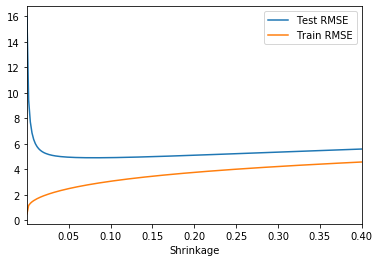

In [44]:
df_agg_metrics.plot()

In [45]:
df_agg_metrics.loc[df_agg_metrics["Test RMSE"].idxmin()]

Test RMSE     4.918897
Train RMSE    2.881802
Name: 0.08041, dtype: float64

# Kernel Ridge Regression

## Example 1: Boston Housing with Polynomial Kernel

In [24]:
from sklearn.kernel_ridge import KernelRidge

In [36]:
def poly_kernel(X, degree):
    return (np.matmul(X, X.transpose())) ** degree
    # return (np.matmul(X, X.transpose()) + 1.0) ** degree  # K(X, Y) = (gamma <X, Y> + coef0)^degree (sklearn implementation)
    # return (np.eye(X.shape[0]) + np.matmul(X, X.transpose())) ** degree  # anova dot-kernel - try it later if you are interested

# passing some parameters
krr_degree = 3
krr_shrinkage = np.linspace(0.00001, 0.4, num=200)

In [37]:
# pre-instantiation
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Shrinkage", "Train RMSE", "Test RMSE"])

# main loop
k, f = 0, 0
for (train, test) in kf.split(df):
    f += 1
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
    
    # scaling variables
    scaler_x = StandardScaler().fit(x_train)
    x_train = scaler_x.transform(x_train)
    x_test = scaler_x.transform(x_test)
    
    # creating kernel matrix
    x_data = np.hstack([np.ones((df.shape[0], 1)), np.vstack([x_train, x_test])])
    # x_data = np.vstack([x_train, x_test]) # no intercept
    K = poly_kernel(x_data, krr_degree)
    
    # splitting kernel matrix in training an test
    # remember: K = |k(x_train, x_train), k(x_test, x_train) |
    #               |k(x_train, x_test), k(x_test, x_test)   |
    # we train using k(x_train, x_train) block, and test using k(x_train, x_test) block
    k_train = K[:x_train.shape[0], :x_train.shape[0]]
    k_test = K[x_train.shape[0]:, :x_train.shape[0]]
        
    # fit model
    for l in krr_shrinkage:
        # train model
        inv_component = np.linalg.inv(k_train + np.eye(x_train.shape[0]) * l * x_train.shape[0])
        coefs = np.matmul(inv_component, y_train)
                
        # get predictions
        pred_train = np.matmul(k_train, coefs)
        pred_test = np.matmul(k_test, coefs)
        
        # compute metrics
        rmse_train = np.sqrt(np.mean((y_train - pred_train) ** 2.0))
        rmse_test = np.sqrt(np.mean((y_test - pred_test) ** 2.0))
        
        # store results
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Shrinkage"] = l
        df_metrics.loc[k, "Train RMSE"] = rmse_train
        df_metrics.loc[k, "Test RMSE"] = rmse_test
        k += 1
        
        # if using sklearn: from sklearn.linear_model import Ridge
        #ml = KernelRidge(kernel="poly", degree=krr_degree, alpha=l).fit(x_train, y_train)
        #pred_train = ml.predict(x_train)
        #pred_test = ml.predict(x_test)

# final organization
df_metrics = df_metrics.astype(float)

### Charts

In [38]:
df_agg_metrics = df_metrics.pivot_table(index="Shrinkage", values=["Train RMSE", "Test RMSE"])

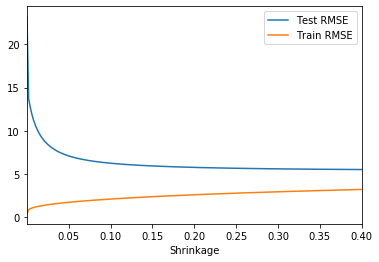

In [39]:
df_agg_metrics.plot()

In [40]:
df_agg_metrics.loc[df_agg_metrics["Test RMSE"].idxmin()]

Test RMSE     5.516402
Train RMSE    3.210919
Name: 0.4, dtype: float64

## Example 2: Boston Housing with Gaussian/RBF Kernel

### Initial Params

In [72]:
def rbf_kernel(X, sigma):
    from sklearn.metrics.pairwise import euclidean_distances
    K = euclidean_distances(X, X, squared=True)
    K *= -sigma
    return np.exp(K, K)  # exponentiate K in-place
    
# passing some parameters
krr_sigma = 0.5
krr_shrinkage = np.linspace(0.00001, 0.4, num=200)

### Main Loop

In [73]:
# pre-instantiation
df_metrics = pd.DataFrame(index=[0], columns=["Fold", "Shrinkage", "Train RMSE", "Test RMSE"])

# main loop
k, f = 0, 0
for (train, test) in kf.split(df):
    f += 1
    # separate variables and folds
    x_train = df.drop(labels=target, axis=1).values[train]
    x_test = df.drop(labels=target, axis=1).values[test]
    y_train = df[target].values[train]
    y_test = df[target].values[test]
    
    # scaling variables
    scaler_x = StandardScaler().fit(x_train)
    x_train = scaler_x.transform(x_train)
    x_test = scaler_x.transform(x_test)
    
    # creating kernel matrix
    x_data = np.hstack([np.ones((df.shape[0], 1)), np.vstack([x_train, x_test])])
    K = rbf_kernel(x_data, krr_sigma)
    
    # splitting kernel matrix in training an test
    # remember: K = |k(x_train, x_train), k(x_test, x_train) |
    #               |k(x_train, x_test), k(x_test, x_test)   |
    # we train using k(x_train, x_train) block, and test using k(x_train, x_test) block
    k_train = K[:x_train.shape[0], :x_train.shape[0]]
    k_test = K[x_train.shape[0]:, :x_train.shape[0]]
        
    # fit model
    for l in krr_shrinkage:
        # train model
        inv_component = np.linalg.inv(k_train + np.eye(x_train.shape[0]) * l * x_train.shape[0])
        coefs = np.matmul(inv_component, y_train)
                
        # get predictions
        pred_train = np.matmul(k_train, coefs)
        pred_test = np.matmul(k_test, coefs)
        
        # compute metrics
        rmse_train = np.sqrt(np.mean((y_train - pred_train) ** 2.0))
        rmse_test = np.sqrt(np.mean((y_test - pred_test) ** 2.0))
        
        # store results
        df_metrics.loc[k, "Fold"] = f
        df_metrics.loc[k, "Shrinkage"] = l
        df_metrics.loc[k, "Train RMSE"] = rmse_train
        df_metrics.loc[k, "Test RMSE"] = rmse_test
        k += 1
        
        # if using sklearn: from sklearn.linear_model import Ridge
        #ml = KernelRidge(kernel="rbf", degree=krr_sigma, alpha=l).fit(x_train, y_train)
        #pred_train = ml.predict(x_train)
        #pred_test = ml.predict(x_test)

# final organization
df_metrics = df_metrics.astype(float)

### Charts

In [74]:
df_agg_metrics = df_metrics.pivot_table(index="Shrinkage", values=["Train RMSE", "Test RMSE"])

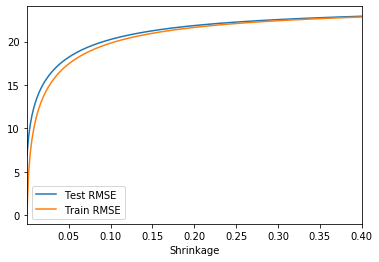

In [76]:
df_agg_metrics.plot()

In [77]:
df_agg_metrics.loc[df_agg_metrics["Test RMSE"].idxmin()]

Test RMSE     6.902539
Train RMSE    0.157527
Name: 1e-05, dtype: float64

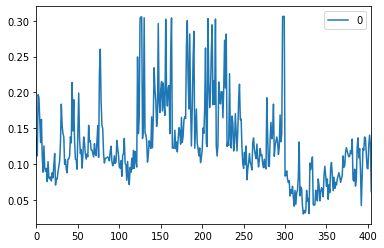

In [78]:
pd.DataFrame(coefs).plot()

# Support Vector Machines

## Linearly separable problem

### Dataset

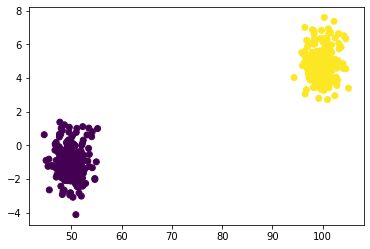

In [79]:
# linearly separable problem
class_plus1 = np.hstack([np.random.normal(loc=[100.0, 5.0], scale=[2.0, 1.0], size=(200, 2)), np.ones((200, 1))])
class_minus1 = np.hstack([np.random.normal(loc=[50.0, -1.0], scale=[2.0, 1.0], size=(200, 2)), -np.ones((200, 1))])
df = pd.DataFrame(np.vstack([class_plus1, class_minus1]), columns=["X", "Z", "Y"])

# plot
plt.scatter(df["X"], df["Z"], c=df["Y"])

### Model

In [80]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# not scaled
svm_unscaled = Pipeline(( ("scaler", StandardScaler(with_mean=False, with_std=False)),
                       ("linear_svc", LinearSVC(loss="hinge", C=10.0 ** -10.0)),
                      ))
svm_unscaled = svm_unscaled.fit(df[["X", "Z"]].values, df["Y"].values)

# with scaling
svm_scaled = Pipeline(( ("scaler", StandardScaler()),
                       ("linear_svc", LinearSVC(loss="hinge", C=10.0 ** -10.0)),
                      ))
svm_scaled = svm_scaled.fit(df[["X", "Z"]].values, df["Y"].values)

### Charts - Sensitivity to feature scales

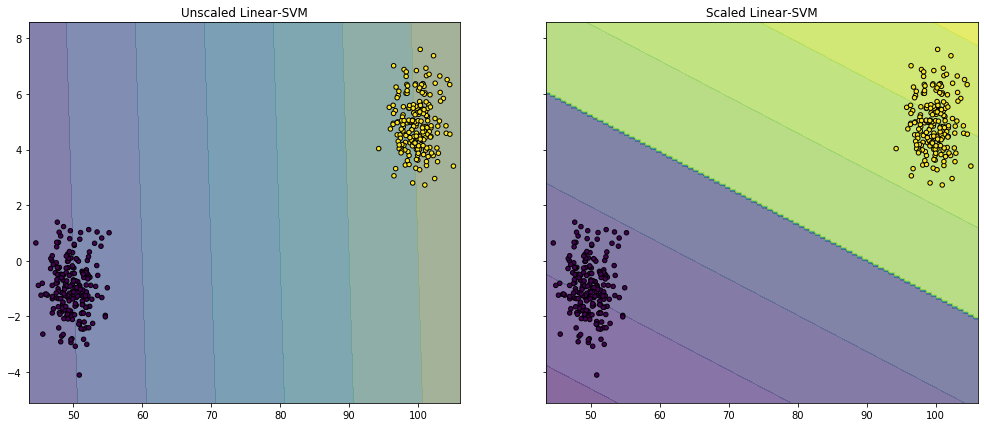

In [81]:
from itertools import product
# Instantiation
x_min, x_max = df["X"].min() - 1, df["X"].max() + 1
z_min, z_max = df["Z"].min() - 1, df["Z"].max() + 1
xx, zz = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(z_min, z_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(17, 7))

# Plotting decision regions
for idx, clf, tt in zip(product([0, 1]), [svm_unscaled, svm_scaled], ["Unscaled Linear-SVM", "Scaled Linear-SVM"]):

    Z = clf.decision_function(np.c_[xx.ravel(), zz.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0]].contourf(xx, zz, Z, alpha=0.4)
    Z = clf.predict(np.c_[xx.ravel(), zz.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0]].contourf(xx, zz, Z, alpha=0.4)
    axarr[idx[0]].scatter(df["X"].values, df["Z"].values, c=df["Y"].values, s=20, edgecolor='k')
    axarr[idx[0]].set_title(tt)

## Soft Margin

### Dataset

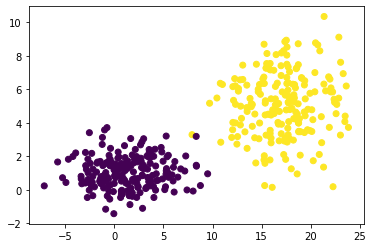

In [82]:
# linearly separable problem, but with outliers
np.random.seed(seed=119)
class_plus1 = np.hstack([np.random.normal(loc=[17.0, 5.0], scale=[3.0, 2.0], size=(200, 2)), np.ones((200, 1))])
class_minus1 = np.hstack([np.random.normal(loc=[1.0, 1.0], scale=[3.0, 1.0], size=(200, 2)), -np.ones((200, 1))])
df = pd.DataFrame(np.vstack([class_plus1, class_minus1]), columns=["X", "Z", "Y"])

# plot
plt.scatter(df["X"], df["Z"], c=df["Y"])

### Model

In [85]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# different penalties
C = [0.0000001, 0.0001, 10.0]

# different models
svm_c = []
for c in C:
    svm_c.append(Pipeline(( ("scaler", StandardScaler()),
                           ("linear_svc", LinearSVC(loss="hinge", C=c)),
                          ))
                )
    svm_c[-1].fit(df[["X", "Z"]].values, df["Y"].values)

### Charts - Fewer vs More margin violations

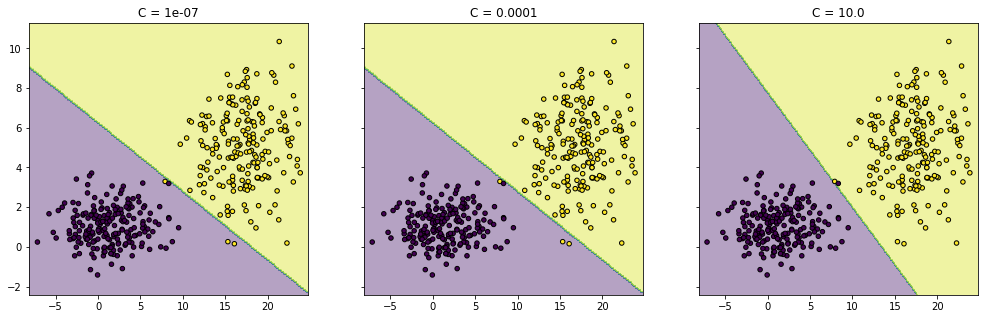

In [86]:
from itertools import product
# Instantiation
x_min, x_max = df["X"].min() - 1, df["X"].max() + 1
z_min, z_max = df["Z"].min() - 1, df["Z"].max() + 1
xx, zz = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(z_min, z_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(17, 5))

# Plotting decision regions
for idx, clf, tt in zip(product([0, 1, 2]), svm_c, ["C = " + str(c) for c in C]):

    Z = clf.predict(np.c_[xx.ravel(), zz.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0]].contourf(xx, zz, Z, alpha=0.4)
    axarr[idx[0]].scatter(df["X"].values, df["Z"].values, c=df["Y"].values, s=20, edgecolor='k')
    axarr[idx[0]].set_title(tt)

## Linear Support Vector Machines with Explicit Feature Map

### Dataset

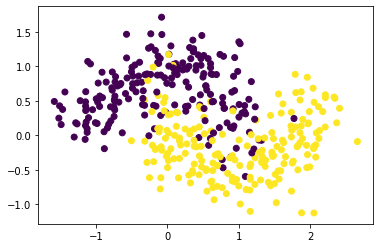

In [95]:
# linearly separable problem, but with outliers
from sklearn.datasets import make_moons
np.random.seed(seed=119)
df = make_moons(n_samples=400, noise=0.3, random_state=0)
df = pd.DataFrame({"X": df[0][:, 0],
                   "Z": df[0][:, 1],
                   "Y": df[1]})

# plot
plt.scatter(df["X"], df["Z"], c=df["Y"])

### Model

In [102]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
# different penalties
degree = [1, 3, 5]

# different models
svm_d = []
for d in degree:
    svm_d.append(Pipeline((("poly_features", PolynomialFeatures(degree=d)), 
                           ("scaler", StandardScaler()),
                           ("linear_svc", LinearSVC(loss="hinge", C=1.0)),
                          ))
                )
    svm_d[-1].fit(df[["X", "Z"]].values, df["Y"].values)

C:\Users\Koshiyama\Anaconda3\envs\mli3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3\envs\mli3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Charts - Nonlinear decision boundary

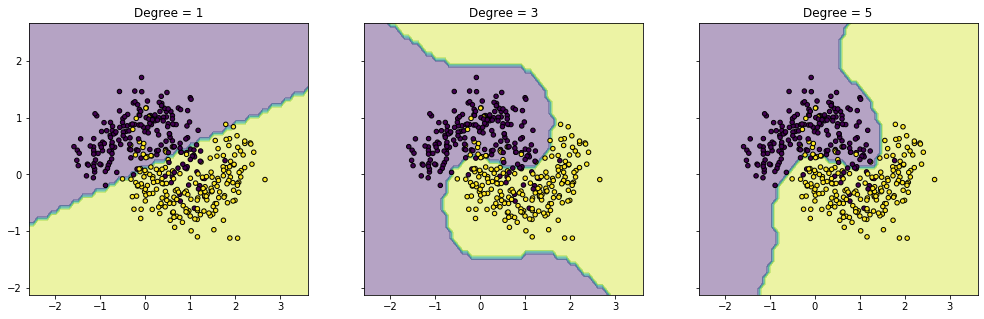

In [103]:
from itertools import product
# Instantiation
x_min, x_max = df["X"].min() - 1, df["X"].max() + 1
z_min, z_max = df["Z"].min() - 1, df["Z"].max() + 1
xx, zz = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(z_min, z_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(17, 5))

# Plotting decision regions
for idx, clf, tt in zip(product([0, 1, 2]), svm_d, ["Degree = " + str(d) for d in degree]):

    Z = clf.predict(np.c_[xx.ravel(), zz.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0]].contourf(xx, zz, Z, alpha=0.4)
    axarr[idx[0]].scatter(df["X"].values, df["Z"].values, c=df["Y"].values, s=20, edgecolor='k')
    axarr[idx[0]].set_title(tt)

## Kernel SVM

### Dataset - Harder to separate...

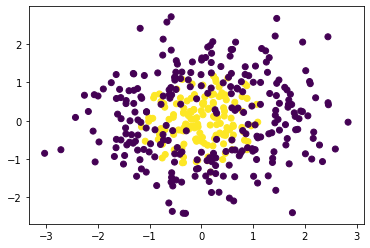

In [105]:
# nonlinearly separable problem
np.random.seed(seed=119)
class_data = np.random.normal(loc=[0.0, 0.0], scale=[1.0, 1.0], size=(400, 2))
class_pos = (class_data[:, 0] ** 2.0 + class_data[:, 1] ** 2.0) < np.random.uniform(low=0.0, high=2., size=400)
class_plus1 = class_data[class_pos, :]
class_minus1 = class_data[class_pos == False, :]
df = pd.DataFrame(np.vstack([np.hstack([class_plus1, np.ones((class_plus1.shape[0], 1))]), 
                            np.hstack([class_minus1, -np.ones((class_minus1.shape[0], 1))])]), columns=["X", "Z", "Y"])

# plot
plt.scatter(df["X"], df["Z"], c=df["Y"])

### Model

In [110]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
# different penalties
sigma = [1., 10.0, 100.0]

# different models
svm_s = []
for s in sigma:
    svm_s.append(Pipeline((("scaler", StandardScaler()),
                           ("kernel_svc", SVC(kernel="rbf", gamma=s, C=10.0)),
                          ))
                )
    svm_s[-1].fit(df[["X", "Z"]].values, df["Y"].values)

### Charts - Hard to separate

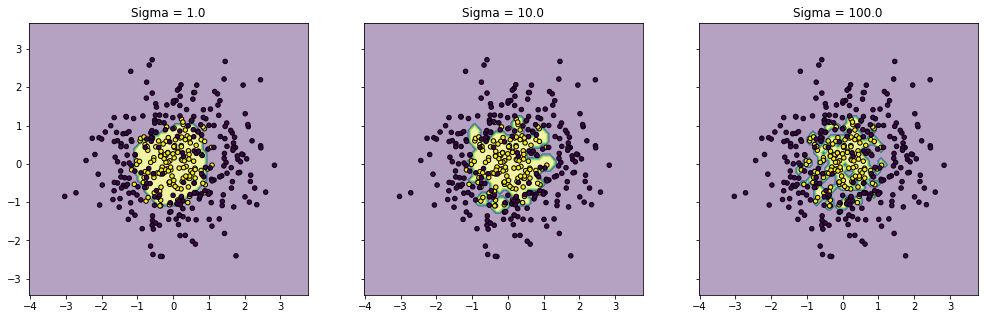

In [111]:
from itertools import product
# Instantiation
x_min, x_max = df["X"].min() - 1, df["X"].max() + 1
z_min, z_max = df["Z"].min() - 1, df["Z"].max() + 1
xx, zz = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(z_min, z_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(17, 5))

# Plotting decision regions
for idx, clf, tt in zip(product([0, 1, 2]), svm_s, ["Sigma = " + str(s) for s in sigma]):

    Z = clf.predict(np.c_[xx.ravel(), zz.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0]].contourf(xx, zz, Z, alpha=0.4)
    axarr[idx[0]].scatter(df["X"].values, df["Z"].values, c=df["Y"].values, s=20, edgecolor='k')
    axarr[idx[0]].set_title(tt)